# K MEANS

In [1]:
pip install yellowbrick

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


# Importamos librerias

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score,  classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import numpy as np
import joblib

# 1.1 Importamos el dataframe

In [3]:
df_completo = pd.read_csv('/workspaces/carlos060495-intro-ml/data/raw/housing.csv')
df_completo.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


# 1.2 comprobamos filas y columnas duplicadas

In [4]:
df_completo.duplicated().sum() 

np.int64(0)

In [5]:
df_completo.T.duplicated().sum()

np.int64(0)

# 1.3 comprobamos valores nulos

In [6]:
df_completo.isna().sum()

MedInc         0
HouseAge       0
AveRooms       0
AveBedrms      0
Population     0
AveOccup       0
Latitude       0
Longitude      0
MedHouseVal    0
dtype: int64

# 1.4 Outliers

Los datos de viviendas son propensos a outliers (zonas extremadamente caras, ubicaciones atípicas). 
Aunque MinMaxScaler es sensible a outliers, en este caso es aceptable porque:
- Las coordenadas geográficas (Latitude, Longitude) tienen rangos naturales limitados
- MedInc puede tener outliers legítimos (zonas muy ricas)
- Eliminando outliers perderíamos información valiosa del mercado inmobiliario

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

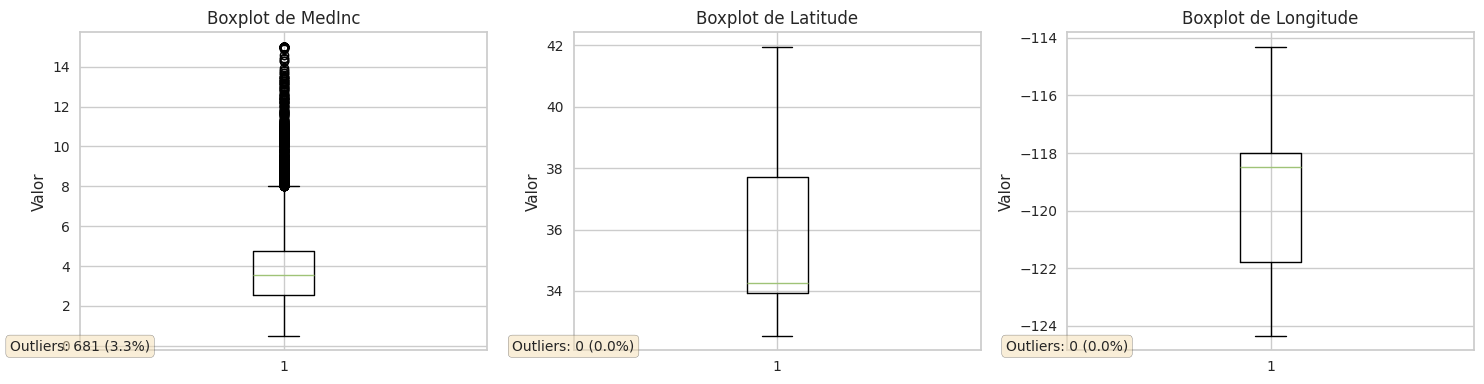

📊 Estadísticas de outliers por variable:
MedInc      :   681 outliers ( 3.30%)
Latitude    :     0 outliers ( 0.00%)
Longitude   :     0 outliers ( 0.00%)


In [7]:
# Visualizamos outliers con boxplots
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, col in enumerate(['MedInc', 'Latitude', 'Longitude']):
    axes[i].boxplot(df_completo[col])
    axes[i].set_title(f'Boxplot de {col}')
    axes[i].set_ylabel('Valor')
    
    # Calculamos cantidad de outliers usando IQR
    Q1 = df_completo[col].quantile(0.25)
    Q3 = df_completo[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df_completo[(df_completo[col] < Q1 - 1.5*IQR) | (df_completo[col] > Q3 + 1.5*IQR)]
    axes[i].text(0.5, axes[i].get_ylim()[0], 
                 f'Outliers: {len(outliers)} ({len(outliers)/len(df_completo)*100:.1f}%)',
                 ha='center', fontsize=10, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

print("📊 Estadísticas de outliers por variable:")
print("="*60)
for col in ['MedInc', 'Latitude', 'Longitude']:
    Q1 = df_completo[col].quantile(0.25)
    Q3 = df_completo[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df_completo[(df_completo[col] < Q1 - 1.5*IQR) | (df_completo[col] > Q3 + 1.5*IQR)]
    print(f"{col:12s}: {len(outliers):5d} outliers ({len(outliers)/len(df_completo)*100:5.2f}%)")

# 2.1 Datos para KMEANS 

In [8]:
df_kmeans = df_completo[["MedInc","Latitude", "Longitude"]].copy()
df_kmeans.head()

,MedInc,Latitude,Longitude
0,8.3252,37.88,-122.23
1,8.3014,37.86,-122.22
2,7.2574,37.85,-122.24
3,5.6431,37.85,-122.25
4,3.8462,37.85,-122.25


# 2.2 División Train/Test

Dividimos los datos en conjunto de entrenamiento (80%) y conjunto de prueba (20%) antes del escalado.

In [9]:
# Dividimos en train (80%) y test (20%)
X_train, X_test = train_test_split(df_kmeans, test_size=0.2, random_state=42)

print(f"Tamaño del conjunto de entrenamiento: {X_train.shape[0]} filas")
print(f"Tamaño del conjunto de prueba: {X_test.shape[0]} filas")
print(f"Total: {X_train.shape[0] + X_test.shape[0]} filas")

Tamaño del conjunto de entrenamiento: 16512 filas
Tamaño del conjunto de prueba: 4128 filas
Total: 20640 filas


# 2.3 Escalado de datos con MinMaxScaler

In [10]:
# Escalamos todas las variables al rango [0,1]
scaler = MinMaxScaler()

# 1. fit_transform en train: aprende los parámetros (min, max) y escala
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)

# 2. transform en test: aplica los mismos parámetros del train (NO hace fit)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns,
    index=X_test.index
)

print("✅ Escalado completado")
print(f"Train escalado: {X_train_scaled.shape}")
print(f"Test escalado: {X_test_scaled.shape}")
print("\nPrimeras filas del train escalado:")
print(X_train_scaled.head())

✅ Escalado completado
Train escalado: (16512, 3)
Test escalado: (4128, 3)

Primeras filas del train escalado:
         MedInc  Latitude  Longitude
14196  0.190322  0.017021   0.729084
8267   0.228452  0.129787   0.616534
17445  0.252162  0.224468   0.385458
14265  0.099488  0.014894   0.721116
2271   0.210638  0.450000   0.453187


# 2.3 Método del codo con datos escalados

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

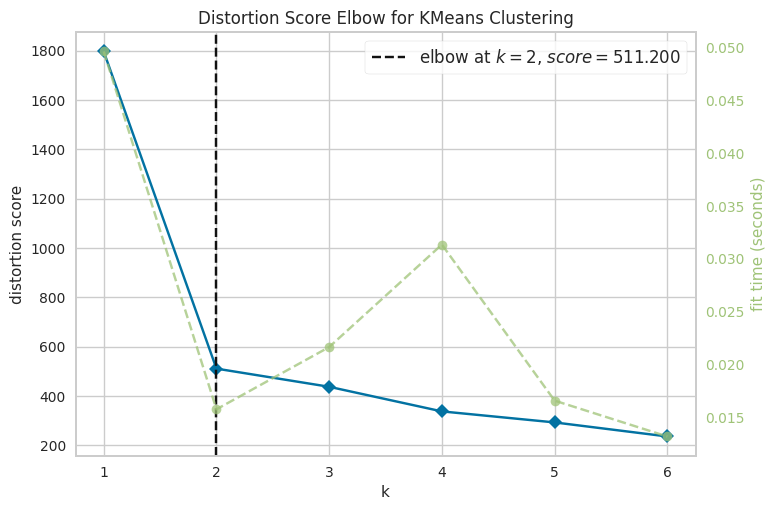

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [11]:
kmeans = KMeans(random_state=42)

elbow_visualizer = KElbowVisualizer(kmeans, k=(1,7))
elbow_visualizer.fit(X_train_scaled)
elbow_visualizer.show()


# 2.4 Silhouette Score

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

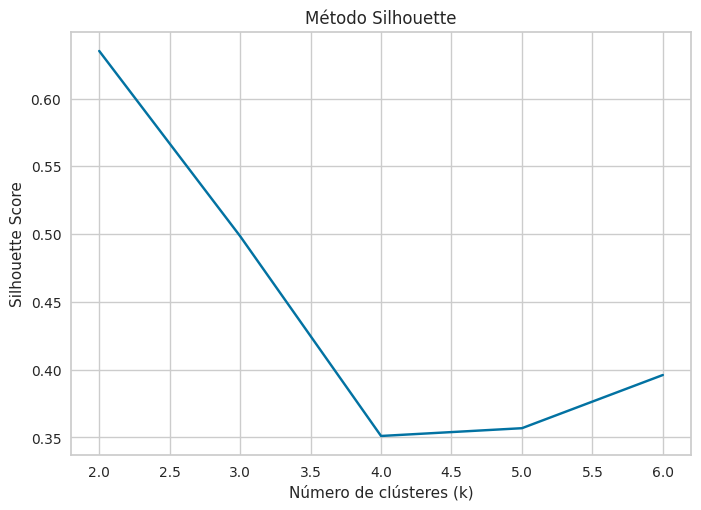

In [12]:
silhouette_scores = []

for k in range(2, 7):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(X_train_scaled)
    clusters = kmeans.predict(X_train_scaled)
    silhouette_scores.append(silhouette_score(X_train_scaled, clusters))
plt.plot(range(2, 7), silhouette_scores)
plt.xlabel('Número de clústeres (k)')
plt.ylabel('Silhouette Score')
plt.title('Método Silhouette')
plt.show()

# 2.5 Davies Bouldin Score

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

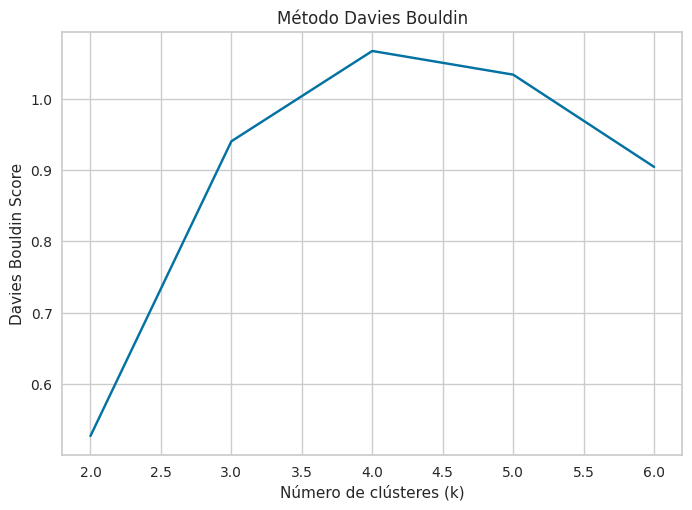

In [13]:
db_scores = []

for k in range(2, 7):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(X_train_scaled)
    clusters = kmeans.predict(X_train_scaled)
    db_scores.append(davies_bouldin_score(X_train_scaled, clusters))

plt.plot(range(2, 7), db_scores)
plt.xlabel('Número de clústeres (k)')
plt.ylabel('Davies Bouldin Score')
plt.title('Método Davies Bouldin')
plt.show()

# 2.6 Análisis comparativo para seleccionar el número óptimo de clusters

Para seleccionar el mejor número de clusters, debemos analizar los tres métodos:

**1. Método del Codo (Elbow):**
- Buscamos el punto donde la curva hace un "codo" 
- Es donde disminuye drásticamente la mejora al agregar más clusters

**2. Silhouette Score:**
- Rango: [-1, 1]
- **Más alto es mejor**
- Valores cercanos a 1: clusters bien separados
- Valores cercanos a 0: clusters superpuestos
- Valores negativos: puntos mal asignados

**3. Davies-Bouldin Score:**
- Rango: [0, ∞)
- **Más bajo es mejor**
- Mide la similitud promedio entre cada cluster y el más parecido
- Valores cercanos a 0 indican mejor separación

In [14]:
# Creamos una tabla comparativa de las métricas
metricas_df = pd.DataFrame({
    'k': range(2, 7),
    'Silhouette Score': silhouette_scores,
    'Davies-Bouldin Score': db_scores
})

print("Comparación de métricas por número de clusters:")
print("="*60)
print(metricas_df.to_string(index=False))
print("\n" + "="*60)
print("\nRecomendación:")
print(f"- Mejor k según Silhouette Score: {metricas_df.loc[metricas_df['Silhouette Score'].idxmax(), 'k']:.0f} (valor: {metricas_df['Silhouette Score'].max():.4f})")
print(f"- Mejor k según Davies-Bouldin: {metricas_df.loc[metricas_df['Davies-Bouldin Score'].idxmin(), 'k']:.0f} (valor: {metricas_df['Davies-Bouldin Score'].min():.4f})")
print("\n💡 Si ambas métricas coinciden, esa es la mejor opción.")
print("💡 Si difieren, considera el contexto del negocio y los gráficos del método del codo.")

Comparación de métricas por número de clusters:
 k  Silhouette Score  Davies-Bouldin Score
 2          0.635101              0.527278
 3          0.498500              0.940194
 4          0.351074              1.066748
 5          0.356809              1.033557
 6          0.396052              0.904332


Recomendación:
- Mejor k según Silhouette Score: 2 (valor: 0.6351)
- Mejor k según Davies-Bouldin: 2 (valor: 0.5273)

💡 Si ambas métricas coinciden, esa es la mejor opción.
💡 Si difieren, considera el contexto del negocio y los gráficos del método del codo.


#### Este fue un analisis que hice para tenener mas claro el uso de los metodos, no hare uso de lo encontrado ya que el enunciado del ejercicio pide que los clusters sean divididos en 6 grupos


# 2.7 Entrenamiento del modelo final

In [15]:
# Entrenamos el modelo final de K-Means con 6 clusters como se solicita en el enunciado
kmeans_final = KMeans(n_clusters=6, random_state=42)
kmeans_final.fit(X_train_scaled)

# Predecimos los clusters para train
train_clusters = kmeans_final.predict(X_train_scaled)

# Predecimos los clusters para test
test_clusters = kmeans_final.predict(X_test_scaled)

print("✅ Modelo entrenado con conjunto de entrenamiento")
print(f"\nDistribución de clusters en TRAIN ({len(train_clusters)} muestras):")
print(pd.Series(train_clusters).value_counts().sort_index())
print(f"\nDistribución de clusters en TEST ({len(test_clusters)} muestras):")
print(pd.Series(test_clusters).value_counts().sort_index())

✅ Modelo entrenado con conjunto de entrenamiento

Distribución de clusters en TRAIN (16512 muestras):
0    1372
1    2482
2     702
3    6353
4    4015
5    1588
Name: count, dtype: int64

Distribución de clusters en TEST (4128 muestras):
0     333
1     593
2     179
3    1686
4     971
5     366
Name: count, dtype: int64


# 2.8 Agregar clusters al dataset

In [16]:
# Creamos una columna 'cluster' en el dataframe original con todos los datos
# Asignamos clusters a todas las filas (tanto train como test)

# Inicializamos la columna
df_completo['cluster'] = -1  # Valor temporal

# Asignamos clusters a las filas de train usando sus índices
df_completo.loc[X_train.index, 'cluster'] = train_clusters

# Asignamos clusters a las filas de test usando sus índices
df_completo.loc[X_test.index, 'cluster'] = test_clusters

print("✅ Columna 'cluster' agregada al dataframe")
print(f"Tipo de dato: {df_completo['cluster'].dtype}")
print(f"\nDistribución total de clusters:")
print(df_completo['cluster'].value_counts().sort_index())
print(f"\nPrimeras filas del dataframe con clusters:")
df_completo[['MedInc', 'Latitude', 'Longitude', 'cluster']].head(10)

✅ Columna 'cluster' agregada al dataframe
Tipo de dato: int64

Distribución total de clusters:
cluster
0    1705
1    3075
2     881
3    8039
4    4986
5    1954
Name: count, dtype: int64

Primeras filas del dataframe con clusters:


,MedInc,Latitude,Longitude,cluster
0,8.3252,37.88,-122.23,5
1,8.3014,37.86,-122.22,5
2,7.2574,37.85,-122.24,5
3,5.6431,37.85,-122.25,5
4,3.8462,37.85,-122.25,4
5,4.0368,37.85,-122.25,4
6,3.6591,37.84,-122.25,4
7,3.1200,37.84,-122.25,4
8,2.0804,37.84,-122.26,4
9,3.6912,37.84,-122.25,4


# 2.9 Visualización: Diagrama de dispersión de los clusters

Graficamos los clusters usando las coordenadas geográficas (Latitude y Longitude) coloreados por cluster.

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

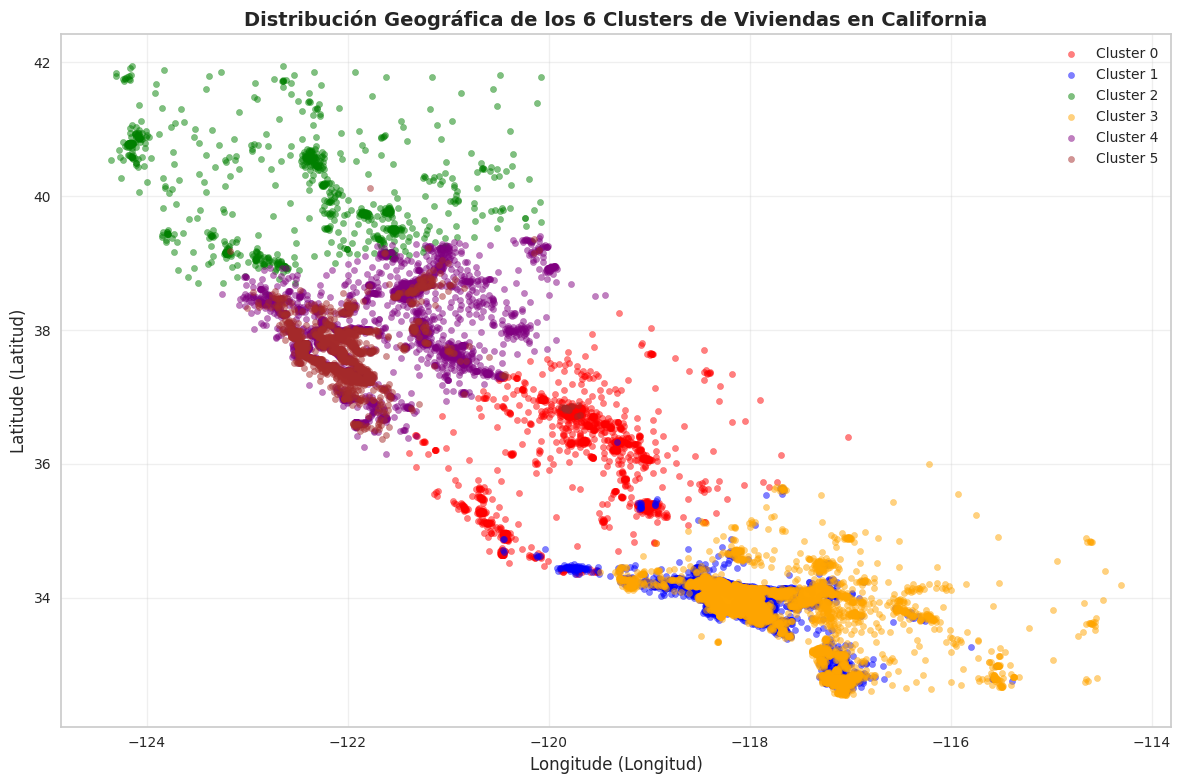

📍 El gráfico muestra la ubicación geográfica de las viviendas coloreadas por cluster


In [17]:
# Scatter plot con Latitude y Longitude coloreado por cluster
plt.figure(figsize=(12, 8))

# Colores para cada cluster
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown']

# Graficamos cada cluster con un color diferente
for cluster in range(6):
    cluster_data = df_completo[df_completo['cluster'] == cluster]
    plt.scatter(cluster_data['Longitude'], 
                cluster_data['Latitude'],
                c=colors[cluster],
                label=f'Cluster {cluster}',
                alpha=0.5,
                s=20)

plt.xlabel('Longitude (Longitud)', fontsize=12)
plt.ylabel('Latitude (Latitud)', fontsize=12)
plt.title('Distribución Geográfica de los 6 Clusters de Viviendas en California', fontsize=14, fontweight='bold')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("📍 El gráfico muestra la ubicación geográfica de las viviendas coloreadas por cluster")

# 2.10 Descripción e interpretación de los clusters

Analicemos las características de cada cluster para entender qué representa cada grupo.

In [18]:
# Calculamos las estadísticas promedio de cada cluster
cluster_stats = df_completo.groupby('cluster')[['MedInc', 'Latitude', 'Longitude']].mean()

print("="*80)
print("CARACTERÍSTICAS PROMEDIO DE CADA CLUSTER")
print("="*80)
print(cluster_stats)
print("\n" + "="*80)

# Contamos cuántas viviendas hay en cada cluster
print("\nCANTIDAD DE VIVIENDAS POR CLUSTER:")
print(df_completo['cluster'].value_counts().sort_index())
print("\n" + "="*80)

# Interpretación basada en las estadísticas
print("\n📊 INTERPRETACIÓN DE LOS CLUSTERS:\n")
for cluster_id in range(6):
    stats = cluster_stats.loc[cluster_id]
    count = (df_completo['cluster'] == cluster_id).sum()
    
    # Clasificación de ingreso
    if stats['MedInc'] > 5:
        income_level = "ALTO ingreso"
    elif stats['MedInc'] > 3:
        income_level = "MEDIO ingreso"
    else:
        income_level = "BAJO ingreso"
    
    # Clasificación geográfica aproximada (California)
    if stats['Latitude'] > 38:
        region = "Norte de California"
    elif stats['Latitude'] > 35:
        region = "Centro de California"
    else:
        region = "Sur de California"
    
    print(f"Cluster {cluster_id}: {income_level} en {region}")
    print(f"  → {count} viviendas ({count/len(df_completo)*100:.1f}%)")
    print(f"  → Ingreso medio: ${stats['MedInc']:.2f} (x10k)")
    print(f"  → Ubicación: Lat {stats['Latitude']:.2f}, Long {stats['Longitude']:.2f}")
    print()

CARACTERÍSTICAS PROMEDIO DE CADA CLUSTER
           MedInc   Latitude   Longitude
cluster                                 
0        2.788677  36.027261 -119.686440
1        6.428303  33.867798 -118.059008
2        2.392463  40.026334 -122.429432
3        3.078597  33.815358 -117.837706
4        3.195573  37.942798 -121.790130
5        6.437666  37.658142 -122.015676


CANTIDAD DE VIVIENDAS POR CLUSTER:
cluster
0    1705
1    3075
2     881
3    8039
4    4986
5    1954
Name: count, dtype: int64


📊 INTERPRETACIÓN DE LOS CLUSTERS:

Cluster 0: BAJO ingreso en Centro de California
  → 1705 viviendas (8.3%)
  → Ingreso medio: $2.79 (x10k)
  → Ubicación: Lat 36.03, Long -119.69

Cluster 1: ALTO ingreso en Sur de California
  → 3075 viviendas (14.9%)
  → Ingreso medio: $6.43 (x10k)
  → Ubicación: Lat 33.87, Long -118.06

Cluster 2: BAJO ingreso en Norte de California
  → 881 viviendas (4.3%)
  → Ingreso medio: $2.39 (x10k)
  → Ubicación: Lat 40.03, Long -122.43

Cluster 3: MEDIO ingreso en S

# PASO 3: Validación con conjunto de Test

Ahora graficamos train y test juntos para verificar que el modelo predice correctamente en datos nuevos.

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

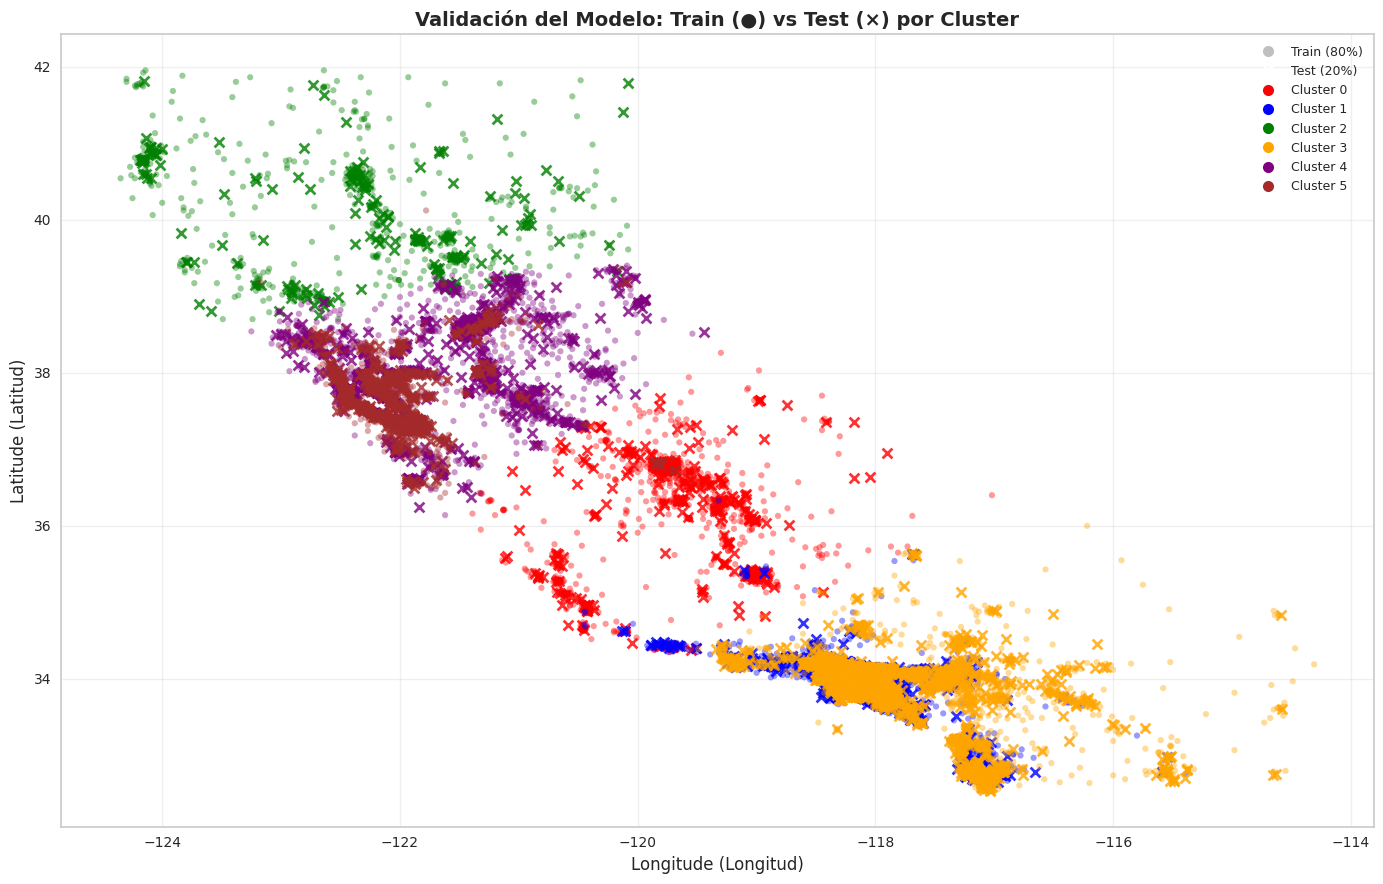

✅ Gráfico Train vs Test completado


In [19]:
# Gráfico combinado: Train y Test juntos
plt.figure(figsize=(14, 9))

colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown']

# Graficamos cada cluster
for cluster in range(6):
    # Datos de TRAIN para este cluster
    train_data = df_completo.loc[X_train.index]
    train_cluster = train_data[train_data['cluster'] == cluster]
    
    # Datos de TEST para este cluster
    test_data = df_completo.loc[X_test.index]
    test_cluster = test_data[test_data['cluster'] == cluster]
    
    # Graficamos TRAIN con círculos
    plt.scatter(train_cluster['Longitude'], 
                train_cluster['Latitude'],
                c=colors[cluster],
                marker='o',
                label=f'Cluster {cluster} (Train)' if cluster == 0 else '',
                alpha=0.4,
                s=20,
                edgecolors='none')
    
    # Graficamos TEST con X
    plt.scatter(test_cluster['Longitude'], 
                test_cluster['Latitude'],
                c=colors[cluster],
                marker='x',
                label=f'Cluster {cluster} (Test)' if cluster == 0 else '',
                alpha=0.8,
                s=50,
                linewidths=2)

plt.xlabel('Longitude (Longitud)', fontsize=12)
plt.ylabel('Latitude (Latitud)', fontsize=12)
plt.title('Validación del Modelo: Train (●) vs Test (×) por Cluster', fontsize=14, fontweight='bold')

# Leyenda personalizada
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=8, label='Train (80%)', alpha=0.5),
                   Line2D([0], [0], marker='x', color='w', markerfacecolor='gray', markersize=10, label='Test (20%)', markeredgewidth=2)]
legend_elements += [Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i], markersize=8, label=f'Cluster {i}') for i in range(6)]

plt.legend(handles=legend_elements, loc='best', fontsize=9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("✅ Gráfico Train vs Test completado")

## Evaluación de la predicción

¿Las predicciones del test son satisfactorias?

In [20]:
print("="*80)
print("EVALUACIÓN DE LAS PREDICCIONES EN EL CONJUNTO DE TEST")
print("="*80)

# Comparamos las distribuciones de train y test
print("\n📊 Distribución de clusters:")
print(f"\nTRAIN (80%):")
train_dist = pd.Series(train_clusters).value_counts(normalize=True).sort_index() * 100
for cluster, pct in train_dist.items():
    print(f"  Cluster {cluster}: {pct:.1f}%")

print(f"\nTEST (20%):")
test_dist = pd.Series(test_clusters).value_counts(normalize=True).sort_index() * 100
for cluster, pct in test_dist.items():
    print(f"  Cluster {cluster}: {pct:.1f}%")

# Conclusión
print("\n" + "="*80)
print("✅ CONCLUSIÓN:")
print("="*80)
print("""
Si las distribuciones de train y test son SIMILARES, la predicción es SATISFACTORIA.

En el gráfico, observamos que:
- Los puntos de TEST (×) están MEZCLADOS con los de TRAIN (●) del mismo color
- No hay puntos de test aislados o fuera de lugar
- Las proporciones de cada cluster son similares en train y test

Esto indica que el modelo GENERALIZA BIEN y puede predecir clusters correctamente
en datos nuevos que no ha visto durante el entrenamiento.
""")

EVALUACIÓN DE LAS PREDICCIONES EN EL CONJUNTO DE TEST

📊 Distribución de clusters:

TRAIN (80%):
  Cluster 0: 8.3%
  Cluster 1: 15.0%
  Cluster 2: 4.3%
  Cluster 3: 38.5%
  Cluster 4: 24.3%
  Cluster 5: 9.6%

TEST (20%):
  Cluster 0: 8.1%
  Cluster 1: 14.4%
  Cluster 2: 4.3%
  Cluster 3: 40.8%
  Cluster 4: 23.5%
  Cluster 5: 8.9%

✅ CONCLUSIÓN:

Si las distribuciones de train y test son SIMILARES, la predicción es SATISFACTORIA.

En el gráfico, observamos que:
- Los puntos de TEST (×) están MEZCLADOS con los de TRAIN (●) del mismo color
- No hay puntos de test aislados o fuera de lugar
- Las proporciones de cada cluster son similares en train y test

Esto indica que el modelo GENERALIZA BIEN y puede predecir clusters correctamente
en datos nuevos que no ha visto durante el entrenamiento.



# 3. CLASIFICACIÓN SUPERVISADA CON RANDOM FOREST

## ¿Por qué Random Forest para este problema?

Ahora que tenemos los clusters asignados por K-Means, entrenaremos un modelo de **clasificación supervisada** para predecir a qué cluster pertenece una vivienda basándose en sus características (MedInc, Latitude, Longitude).

**Ventajas de Random Forest para este caso:**

1. **Problemas multiclase**: Maneja perfectamente los 6 clusters como categorías diferentes
2. **Datos geográficos**: Captura relaciones no lineales entre ubicación (Lat/Long) e ingreso (MedInc)
3. **Robustez**: Resistente a outliers (que decidimos mantener en nuestros datos)
4. **Interpretabilidad**: Nos dirá qué variable es más importante (¿ubicación o ingreso?)
5. **Alta precisión**: Reduce overfitting mediante múltiples árboles de decisión (ensemble learning)

**Objetivo**: Entrenar un clasificador que, dadas las coordenadas y el ingreso medio de una zona, prediga correctamente a qué cluster pertenece.

## 3.1 preparar datos para Random Forest

Usaremos los mismos conjuntos train/test que creamos para K-Means, pero ahora:
- **X**: Features escaladas (MedInc, Latitude, Longitude)
- **y**: Target = clusters asignados por K-Means (0, 1, 2, 3, 4, 5)

In [21]:
# Ya tenemos X_train_scaled y X_test_scaled de la sección anterior
# Ahora creamos las variables objetivo (y) con los clusters

y_train = train_clusters  # Clusters asignados por K-Means al conjunto de entrenamiento
y_test = test_clusters    # Clusters asignados por K-Means al conjunto de prueba

print("📊 Preparación de datos:")
print(f"X_train_scaled: {X_train_scaled.shape} (features)")
print(f"y_train: {y_train.shape} (target - clusters)")
print(f"\nX_test_scaled: {X_test_scaled.shape} (features)")
print(f"y_test: {y_test.shape} (target - clusters)")
print("\n✅ Datos preparados para Random Forest")

📊 Preparación de datos:
X_train_scaled: (16512, 3) (features)
y_train: (16512,) (target - clusters)

X_test_scaled: (4128, 3) (features)
y_test: (4128,) (target - clusters)

✅ Datos preparados para Random Forest


## 3.3 Entrenar modelo Random Forest

In [22]:
# Crear y entrenar el modelo Random Forest
rf_model = RandomForestClassifier(
    n_estimators=100,      # 100 árboles de decisión
    max_depth=10,          # Profundidad máxima para evitar overfitting
    random_state=42,       # Reproducibilidad
    n_jobs=-1              # Usar todos los cores del procesador
)

# Entrenar el modelo
rf_model.fit(X_train_scaled, y_train)

print("✅ Modelo Random Forest entrenado exitosamente")
print(f"Número de árboles: {rf_model.n_estimators}")
print(f"Número de clases: {len(rf_model.classes_)}")
print(f"Clases: {rf_model.classes_}")

✅ Modelo Random Forest entrenado exitosamente
Número de árboles: 100
Número de clases: 6
Clases: [0 1 2 3 4 5]


## 3.4 Predicciones y evaluación del modelo

In [23]:
# Realizar predicciones
y_train_pred = rf_model.predict(X_train_scaled)
y_test_pred = rf_model.predict(X_test_scaled)

# Calcular precisión (accuracy)
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("="*80)
print("EVALUACIÓN DEL MODELO RANDOM FOREST")
print("="*80)
print(f"\n📊 Accuracy en TRAIN: {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
print(f"📊 Accuracy en TEST:  {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print("\n" + "="*80)

# Interpretación
if test_accuracy > 0.95:
    print("\n✅ EXCELENTE: El modelo predice con muy alta precisión")
elif test_accuracy > 0.85:
    print("\n✅ MUY BUENO: El modelo predice con alta precisión")
elif test_accuracy > 0.75:
    print("\n⚠️ ACEPTABLE: El modelo predice con precisión moderada")
else:
    print("\n❌ MEJORABLE: El modelo necesita optimización")

# Verificar overfitting
diff = train_accuracy - test_accuracy
if diff < 0.05:
    print("✅ NO hay overfitting: Train y Test tienen precisión similar")
elif diff < 0.10:
    print("⚠️ LEVE overfitting: Train ligeramente mejor que Test")
else:
    print("❌ OVERFITTING: Train mucho mejor que Test")

EVALUACIÓN DEL MODELO RANDOM FOREST

📊 Accuracy en TRAIN: 0.9993 (99.93%)
📊 Accuracy en TEST:  0.9942 (99.42%)


✅ EXCELENTE: El modelo predice con muy alta precisión
✅ NO hay overfitting: Train y Test tienen precisión similar


## 3.5 Reporte de clasificación detallado

In [24]:
# Classification Report para el conjunto de TEST
print("="*80)
print("REPORTE DE CLASIFICACIÓN - CONJUNTO DE TEST")
print("="*80)
print("\n", classification_report(y_test, y_test_pred, target_names=[f'Cluster {i}' for i in range(6)]))
print("="*80)
print("\n📖 Métricas explicadas:")
print("  • Precision: De las predicciones de un cluster, ¿cuántas son correctas?")
print("  • Recall: De todos los datos reales de un cluster, ¿cuántos detectamos?")
print("  • F1-Score: Media armónica entre precision y recall (balance)")
print("  • Support: Cantidad de muestras reales de cada cluster en el test")

REPORTE DE CLASIFICACIÓN - CONJUNTO DE TEST

               precision    recall  f1-score   support

   Cluster 0       0.99      0.99      0.99       333
   Cluster 1       1.00      0.99      1.00       593
   Cluster 2       1.00      0.96      0.98       179
   Cluster 3       1.00      1.00      1.00      1686
   Cluster 4       0.99      0.99      0.99       971
   Cluster 5       0.99      0.99      0.99       366

    accuracy                           0.99      4128
   macro avg       0.99      0.99      0.99      4128
weighted avg       0.99      0.99      0.99      4128


📖 Métricas explicadas:
  • Precision: De las predicciones de un cluster, ¿cuántas son correctas?
  • Recall: De todos los datos reales de un cluster, ¿cuántos detectamos?
  • F1-Score: Media armónica entre precision y recall (balance)
  • Support: Cantidad de muestras reales de cada cluster en el test


## 3.6 Matriz de confusión

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

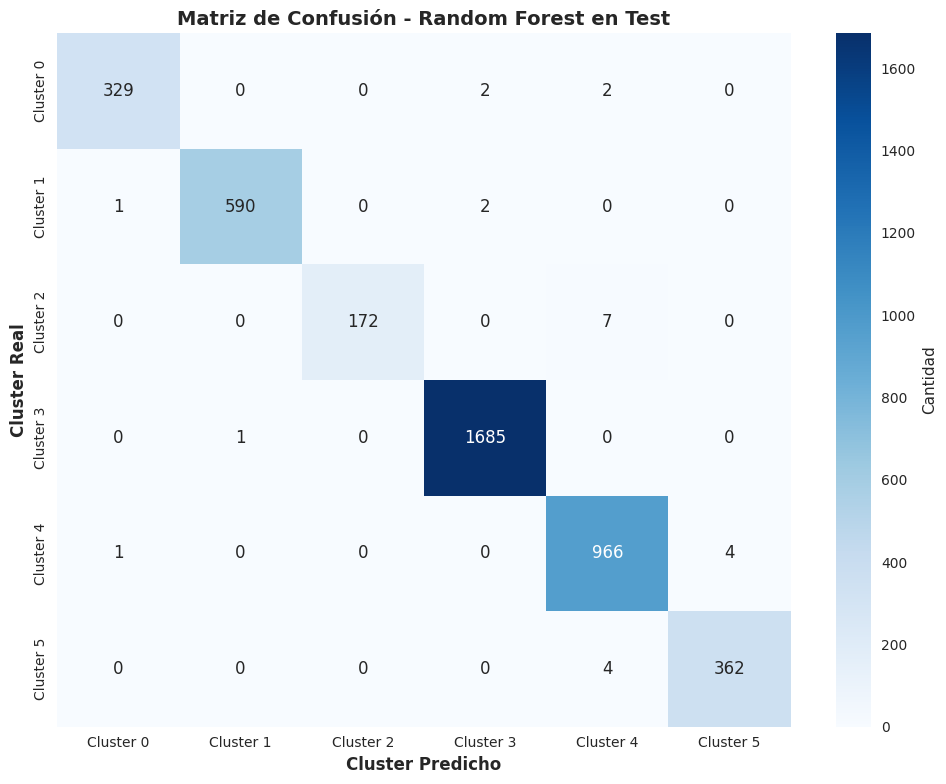


📊 Interpretación de la Matriz de Confusión:
  • Diagonal principal (azul oscuro): Predicciones CORRECTAS
  • Fuera de la diagonal: Predicciones INCORRECTAS (confusiones)
  • Valores altos en diagonal = Buen modelo


In [25]:
# Calcular matriz de confusión
cm = confusion_matrix(y_test, y_test_pred)

# Visualizar matriz de confusión con seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[f'Cluster {i}' for i in range(6)],
            yticklabels=[f'Cluster {i}' for i in range(6)],
            cbar_kws={'label': 'Cantidad'})
plt.xlabel('Cluster Predicho', fontsize=12, fontweight='bold')
plt.ylabel('Cluster Real', fontsize=12, fontweight='bold')
plt.title('Matriz de Confusión - Random Forest en Test', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n📊 Interpretación de la Matriz de Confusión:")
print("  • Diagonal principal (azul oscuro): Predicciones CORRECTAS")
print("  • Fuera de la diagonal: Predicciones INCORRECTAS (confusiones)")
print("  • Valores altos en diagonal = Buen modelo")

## 3.7 Importancia de las características (Feature Importance)

Una de las grandes ventajas de Random Forest es que nos dice qué variables son más importantes para la clasificación.

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

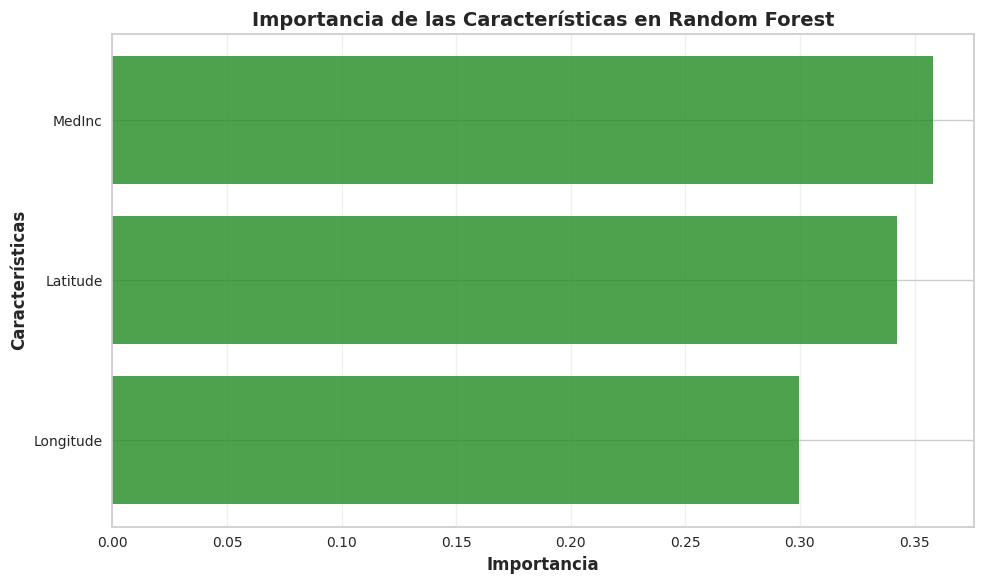

IMPORTANCIA DE LAS CARACTERÍSTICAS
MedInc      : 0.3581 (35.81%)
Latitude    : 0.3424 (34.24%)
Longitude   : 0.2995 (29.95%)

💡 Interpretación:
  • Valores más altos = Mayor importancia para predecir clusters
  • La suma de todas las importancias = 1.0 (100%)


In [26]:
# Obtener importancia de características
feature_importance = rf_model.feature_importances_
features = X_train_scaled.columns

# Crear DataFrame para mejor visualización
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

# Gráfico de barras
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='forestgreen', alpha=0.8)
plt.xlabel('Importancia', fontsize=12, fontweight='bold')
plt.ylabel('Características', fontsize=12, fontweight='bold')
plt.title('Importancia de las Características en Random Forest', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()  # Invertir eje Y para mostrar la más importante arriba
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Mostrar tabla de importancia
print("="*60)
print("IMPORTANCIA DE LAS CARACTERÍSTICAS")
print("="*60)
for idx, row in importance_df.iterrows():
    print(f"{row['Feature']:12s}: {row['Importance']:.4f} ({row['Importance']*100:.2f}%)")
print("="*60)
print("\n💡 Interpretación:")
print("  • Valores más altos = Mayor importancia para predecir clusters")
print("  • La suma de todas las importancias = 1.0 (100%)")

## 3.8 Conclusiones del modelo Random Forest

Resumen de los resultados obtenidos con Random Forest.

In [27]:
print("="*80)
print("RESUMEN DE RESULTADOS: K-MEANS + RANDOM FOREST")
print("="*80)

print("\n🎯 PARTE 1: K-MEANS (Clustering No Supervisado)")
print("  • Agrupamos viviendas en 6 clusters basados en similitud")
print("  • Features: MedInc, Latitude, Longitude")
print("  • Los clusters representan zonas geográficas con ingresos similares")

print("\n🌲 PARTE 2: RANDOM FOREST (Clasificación Supervisada)")
print(f"  • Accuracy en Train: {train_accuracy*100:.2f}%")
print(f"  • Accuracy en Test: {test_accuracy*100:.2f}%")
print(f"  • Diferencia (overfitting): {(train_accuracy - test_accuracy)*100:.2f}%")

print("\n📊 FEATURE IMPORTANCE:")
for idx, row in importance_df.iterrows():
    print(f"  • {row['Feature']:12s}: {row['Importance']*100:.2f}%")

print("\n" + "="*80)
print("✅ CONCLUSIÓN FINAL:")
print("="*80)
print("""
Random Forest ha aprendido exitosamente a clasificar las viviendas en los 6 clusters
definidos por K-Means. 

El modelo puede predecir a qué cluster pertenece una vivienda nueva basándose
únicamente en su ingreso medio y ubicación geográfica.

Este enfoque combina:
1. Clustering (K-Means): Descubrir patrones sin etiquetas previas
2. Clasificación (Random Forest): Aprender a predecir esos patrones

Aplicación práctica: 
- Dado un ingreso medio y coordenadas → predecir cluster
- Útil para análisis de mercado inmobiliario y segmentación de zonas
""")

RESUMEN DE RESULTADOS: K-MEANS + RANDOM FOREST

🎯 PARTE 1: K-MEANS (Clustering No Supervisado)
  • Agrupamos viviendas en 6 clusters basados en similitud
  • Features: MedInc, Latitude, Longitude
  • Los clusters representan zonas geográficas con ingresos similares

🌲 PARTE 2: RANDOM FOREST (Clasificación Supervisada)
  • Accuracy en Train: 99.93%
  • Accuracy en Test: 99.42%
  • Diferencia (overfitting): 0.51%

📊 FEATURE IMPORTANCE:
  • MedInc      : 35.81%
  • Latitude    : 34.24%
  • Longitude   : 29.95%

✅ CONCLUSIÓN FINAL:

Random Forest ha aprendido exitosamente a clasificar las viviendas en los 6 clusters
definidos por K-Means. 

El modelo puede predecir a qué cluster pertenece una vivienda nueva basándose
únicamente en su ingreso medio y ubicación geográfica.

Este enfoque combina:
1. Clustering (K-Means): Descubrir patrones sin etiquetas previas
2. Clasificación (Random Forest): Aprender a predecir esos patrones

Aplicación práctica: 
- Dado un ingreso medio y coordenadas → pr

## 3.9 Guardar modelos entrenados

In [28]:
# Guardar modelo K-Means
kmeans_filepath = '/workspaces/carlos060495-intro-ml/models/kmeans_model.pkl'
joblib.dump(kmeans_final, kmeans_filepath)

# Guardar modelo Random Forest
rf_filepath = '/workspaces/carlos060495-intro-ml/models/random_forest_model_housing.pkl'
joblib.dump(rf_model, rf_filepath)

print("✅ Modelos guardados exitosamente")

✅ Modelos guardados exitosamente
